In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Filtering all the warnings sign

In [2]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

#### Loading the data 

In [3]:
train_df = pd.read_csv('../input/nlp-getting-started/train.csv',usecols=['id','text','target'])
test_df = pd.read_csv('../input/nlp-getting-started/test.csv',usecols=['id','text'])
sample_df = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

here sample_df shows up the format of data to be uploaded on kaggle comptetions

In [4]:
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.shape

(7613, 3)

#### We need to do some text cleaning
here some signs and characters need to be removed , again cleaning the text data before training is a good practice well bert is more advanced architecture , it doesn't much affect if we dont do data cleaning 
, bert dont need extensive text_cleaning because bert comes with 40/60000 words hence its really not necessary to do text_cleaning but removing the special characters are good practice

In [7]:
!pip install text_hammer 

     |████████████████████████████████| 115 kB 4.1 MB/s eta 0:00:01


In [8]:
import text_hammer as th

In [9]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 266 µs, sys: 0 ns, total: 266 µs
Wall time: 255 µs


In [10]:
train_cleaned_df = text_preprocessing(train_df,'text')


  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [11]:
train_cleaned_df[train_cleaned_df.target == 0]

,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0
...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0
7582,10834,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,these boxes are ready to explode exploding kit...,0
7587,10841,sirens everywhere,0


In [12]:
train_df = train_cleaned_df.copy()

here target 1 means we are talking about any accident or disaster and 0 means just a formal tweets with not much attention

so far we have cleaned our text data and now lets load our model

#### Loading Pretrained BERT Model

In [13]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
tokenizer('this is me abhishek and i am a very bad boy &*&*&&')

{'input_ids': [101, 2023, 2003, 2033, 11113, 24158, 5369, 2243, 1998, 1045, 2572, 1037, 2200, 2919, 2879, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

#### Convert Our text data into BERT input format 

In [15]:
print("max len of tweets",max([len(x.split()) for x in train_df.text]))
max_length = 36

max len of tweets 31


In [16]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [17]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [18]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [19]:
y_train = train_df.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

#### Building the model architecture 

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [22]:
max_len = 36
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
# for training bert our lr must be so small

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 36)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 36)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 1024)         0           tf_bert_model[0][1]          

In [24]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

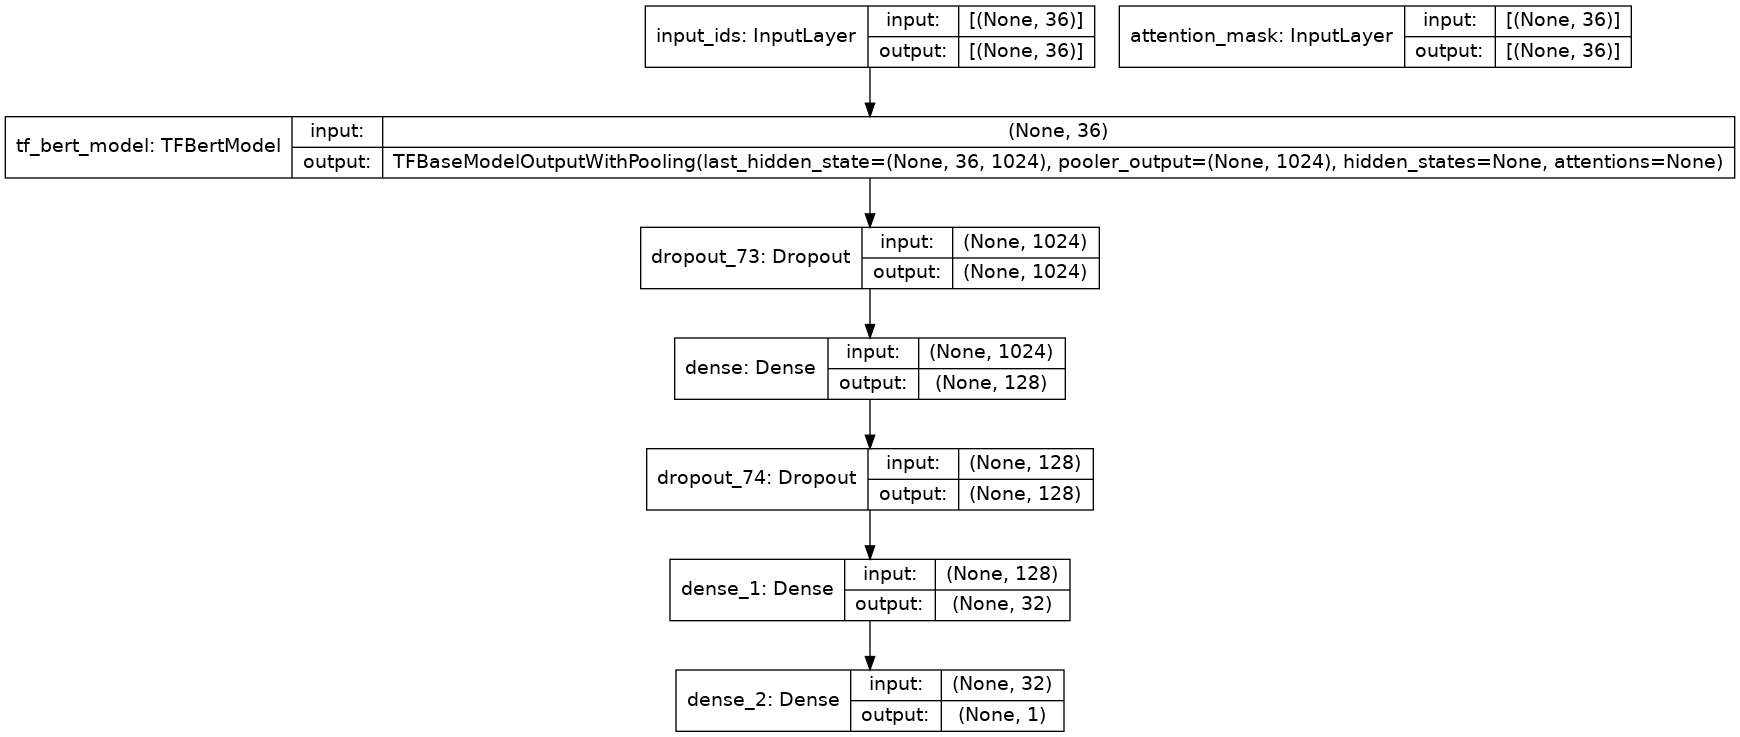

In [25]:
plot_model(model, show_shapes = True)

In [26]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#     validation_split = 0.1,
  epochs=10,
    batch_size=10
)

Epoch 1/10
762/762 [==============================] - 208s 225ms/step - loss: 0.5817 - accuracy: 0.6943
Epoch 2/10
762/762 [==============================] - 171s 225ms/step - loss: 0.4106 - accuracy: 0.8346
Epoch 3/10
762/762 [==============================] - 171s 225ms/step - loss: 0.3878 - accuracy: 0.8457
Epoch 4/10
762/762 [==============================] - 171s 225ms/step - loss: 0.3750 - accuracy: 0.8540
Epoch 5/10
401/762 [==============>...............] - ETA: 1:21 - loss: 0.3949 - accuracy: 0.8411

#### TESTING PHASE
on this phase we will make predictions out of our model and then submit to kaggle comptetions

In [ ]:
test_df

In [ ]:
# test_df = text_preprocessing(test_df,'text')
# without cleaning the model gives better accuracy on uplaoding 

In [ ]:
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [ ]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [ ]:
y_predicted = np.where(predicted>0.5,1,0)

In [ ]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [ ]:
sample_df['id'] = test_df.id
sample_df['target'] = y_predicted

In [ ]:
sample_df.to_csv('submission4.csv',index = False)